# Test Unified Few-Shot Selector for All Datasets

This notebook demonstrates the unified few-shot example selection module working with:
- CholecSeg8k (12 organ classes)
- CholecOrgans (3 organ classes)
- CholecGoNoGo (2 Go/NoGo classes)

In [1]:
import sys
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Add src to path
sys.path.insert(0, '/shared_data0/weiqiuy/llm_cholec_organ/src')

from endopoint.datasets import build_dataset
from endopoint.fewshot import UnifiedFewShotSelector

print("✅ Modules imported successfully")

✅ Modules imported successfully


In [2]:
# Common configuration for all datasets
CONFIG = {
    "n_test_samples": 200,     # Number of balanced test samples (200 for each dataset)
    "n_pos_examples": 1,       # Positive examples per class
    "n_neg_absent": 1,         # Negative examples where class is absent
    "n_neg_wrong": 1,          # Negative examples with wrong answer
    "min_pixels": 50,          # Minimum pixels for presence
    "seed": 42,                # Random seed
    "max_samples": None,       # Process all samples to get better balance
    "use_advanced": True,      # Use advanced selection with rare boosting
}

# Dataset configurations with PUBLIC as default
DATASET_CONFIGS = {
    "cholecseg8k_local": {
        "data_dir": "/shared_data0/weiqiuy/datasets/cholecseg8k"
    },
    "cholec_organs": {
        "data_dir": "/shared_data0/weiqiuy/real_drs/data/abdomen_exlib",
        "video_globs": "public",  # Default to public
        "gen_seed": 56,
        "train_val_seed": 0
    },
    "cholec_gonogo": {
        "data_dir": "/shared_data0/weiqiuy/real_drs/data/abdomen_exlib",
        "video_globs": "public",  # Default to public
        "gen_seed": 56,
        "train_val_seed": 0
    }
}

print("Configuration set:")
print(f"  Test samples: {CONFIG['n_test_samples']}")
print(f"  Max samples to process: {CONFIG['max_samples'] if CONFIG['max_samples'] else 'All'}")
print(f"  Advanced selection: {CONFIG['use_advanced']}")

Configuration set:
  Test samples: 200
  Max samples to process: All
  Advanced selection: True


In [3]:
def test_dataset(dataset_name, visualize=True):
    """Test unified few-shot selector on a dataset.
    
    Args:
        dataset_name: Name of the dataset
        visualize: Whether to show visualizations
    
    Returns:
        Dictionary with results
    """
    print("\n" + "="*70)
    print(f"Testing: {dataset_name}")
    print("="*70)
    
    # Load dataset
    dataset_config = DATASET_CONFIGS[dataset_name]
    dataset = build_dataset(dataset_name, **dataset_config)
    
    print(f"\n📊 Dataset Info:")
    print(f"  Tag: {dataset.dataset_tag}")
    print(f"  Train: {dataset.total('train')} examples")
    print(f"  Val: {dataset.total('validation')} examples")
    print(f"  Test: {dataset.total('test')} examples")
    print(f"  Classes: {len(dataset.label_ids)}")
    
    # Print class names
    print(f"\n  Class mapping:")
    for cid in dataset.label_ids:
        print(f"    {cid}: {dataset.id2label[cid]}")
    
    # Create output directory
    output_dir = Path(f"/shared_data0/weiqiuy/llm_cholec_organ/data_info/{dataset_name}_balanced_200")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create unified selector
    selector = UnifiedFewShotSelector(
        dataset=dataset,
        output_dir=output_dir,
        n_test_samples=CONFIG['n_test_samples'],  # 200 samples
        n_pos_examples=CONFIG['n_pos_examples'],
        n_neg_absent=CONFIG['n_neg_absent'],
        n_neg_wrong=CONFIG['n_neg_wrong'],
        min_pixels=CONFIG['min_pixels'],
        seed=CONFIG['seed'],
        cache_enabled=True
    )
    
    print(f"\n📁 Output directory: {selector.output_dir}")
    
    # Step 1: Compute presence matrix for ALL training samples
    print(f"\n🔄 Step 1: Computing presence matrix for ALL training samples...")
    Y = selector.compute_presence_matrix("train", max_samples=CONFIG['max_samples'])  # None = all samples
    print(f"  Presence matrix shape: {Y.shape}")
    
    # Calculate and display class statistics
    class_counts = Y.sum(axis=0)
    class_percentages = (class_counts / Y.shape[0]) * 100
    
    print(f"\n📊 Class distribution in training set:")
    for i, cid in enumerate(dataset.label_ids):
        name = dataset.id2label[cid]
        count = class_counts[i]
        pct = class_percentages[i]
        print(f"  {name:30} {count:6d} samples ({pct:5.1f}%)")
    
    # Identify rare classes
    rare_threshold = 20  # Classes with less than 20% presence
    rare_classes = []
    for i, cid in enumerate(dataset.label_ids):
        if class_percentages[i] < rare_threshold:
            rare_classes.append(dataset.id2label[cid])
    
    if rare_classes:
        print(f"\n🔴 Rare classes (<{rare_threshold}%): {rare_classes}")
    
    if visualize:
        visualize_class_distribution(Y, dataset, "Training Set Distribution")
    
    # Step 2: Select 200 balanced test samples
    print(f"\n🔄 Step 2: Selecting {CONFIG['n_test_samples']} balanced test samples...")
    
    # Auto-configure parameters for better balance
    n_classes = len(dataset.label_ids)
    rare_top_k = min(4, max(1, n_classes // 3))
    
    # FIXED: Use 20% of n_test_samples as minimum quota, not fixed 20
    min_quota_rare = int(0.20 * CONFIG['n_test_samples'])  # 20% of 200 = 40 samples
    
    print(f"  Configuration:")
    print(f"    - Rare class boost: top {rare_top_k} rarest classes")
    print(f"    - Min quota for rare classes: {min_quota_rare} samples ({min_quota_rare/CONFIG['n_test_samples']*100:.0f}%)")
    print(f"    - Cap for abundant classes: 70% of ideal balanced distribution")
    
    test_indices, selection_info = selector.select_balanced_test_set(
        Y=Y,
        split="train",
        use_advanced=CONFIG['use_advanced'],
        rare_top_k=rare_top_k,
        min_quota_rare=min_quota_rare,
        max_cap_frac=0.70
    )
    
    print(f"  Selected {len(test_indices)} test samples")
    if selection_info and 'rare_order_cols' in selection_info:
        rare_classes = [dataset.id2label[dataset.label_ids[i]] for i in selection_info['rare_order_cols']]
        print(f"  Rare classes boosted: {rare_classes}")
        print(f"  Actual quota used: {selection_info.get('min_quota', min_quota_rare)}")
        print(f"  Cap fraction: {selection_info.get('cap_frac', 0.7):.1%}")
    
    # Analyze selection quality
    Y_selected = Y[test_indices]
    selected_counts = Y_selected.sum(axis=0)
    selected_percentages = (selected_counts / len(test_indices)) * 100
    
    print(f"\n📊 Selected test set distribution:")
    for i, cid in enumerate(dataset.label_ids):
        name = dataset.id2label[cid]
        orig_pct = class_percentages[i]
        sel_count = selected_counts[i]
        sel_pct = selected_percentages[i]
        improvement = sel_pct - orig_pct
        
        # Color code the improvement
        if improvement > 5:
            marker = "⬆️"  # Boosted
        elif improvement < -5:
            marker = "⬇️"  # Reduced
        else:
            marker = "➡️"  # Similar
            
        print(f"  {name:30} {sel_count:3d} samples ({sel_pct:5.1f}%) "
              f"{marker} (was {orig_pct:5.1f}%)")
    
    # Calculate balance score
    orig_std = np.std(class_percentages)
    selected_std = np.std(selected_percentages)
    balance_improvement = ((orig_std - selected_std) / orig_std) * 100 if orig_std > 0 else 0
    
    print(f"\n📈 Balance Metrics:")
    print(f"  Original StdDev: {orig_std:.2f}%")
    print(f"  Selected StdDev: {selected_std:.2f}%")
    print(f"  Balance Improvement: {balance_improvement:.1f}%")
    
    # Visualize selection quality
    if visualize and len(test_indices) > 0:
        compare_distributions(Y, Y_selected, dataset, "Training Pool", "Selected Test Set (n=200)")
    
    # Step 3: Build pointing examples
    if selector.supports_pointing:
        print(f"\n🔄 Step 3: Building pointing examples...")
        pointing_plan = selector.build_pointing_examples(Y, test_indices, "train")
        if pointing_plan:
            total_pointing = sum(
                len(info['positives']) + len(info['negatives_absent']) + 
                len(info.get('negatives_wrong_point', []))
                for info in pointing_plan['plan'].values()
            )
            print(f"  Created {total_pointing} pointing examples")
    else:
        print(f"\n⏭️ Step 3: Skipping pointing (not supported)")
        pointing_plan = None
    
    # Step 4: Build bbox examples
    if selector.supports_bbox:
        print(f"\n🔄 Step 4: Building bounding box examples...")
        bbox_plan = selector.build_bbox_examples(Y, test_indices, "train")
        if bbox_plan:
            total_bbox = sum(
                len(info['positives']) + len(info['negatives_absent']) + 
                len(info.get('negatives_wrong_bbox', []))
                for info in bbox_plan['plan'].values()
            )
            print(f"  Created {total_bbox} bbox examples")
    else:
        print(f"\n⏭️ Step 4: Skipping bounding boxes (not supported)")
        bbox_plan = None
    
    # Print summary
    selector.print_summary(pointing_plan, bbox_plan, selection_info)
    
    # Save detailed results
    results = {
        'dataset_name': dataset_name,
        'n_classes': len(dataset.label_ids),
        'n_train_total': Y.shape[0],
        'n_test_selected': len(test_indices),
        'presence_matrix_shape': Y.shape,
        'test_indices': test_indices,
        'selection_info': selection_info,
        'pointing_plan': pointing_plan,
        'bbox_plan': bbox_plan,
        'output_dir': str(output_dir),
        'balance_metrics': {
            'original_stddev': float(orig_std),
            'selected_stddev': float(selected_std),
            'improvement_percent': float(balance_improvement)
        }
    }
    
    # Save summary to file
    summary_file = output_dir / "test_summary.json"
    with open(summary_file, 'w') as f:
        json.dump({
            'dataset_name': dataset_name,
            'n_test_samples': len(test_indices),
            'balance_metrics': results['balance_metrics'],
            'class_distribution': {
                'original': class_percentages.tolist(),
                'selected': selected_percentages.tolist()
            }
        }, f, indent=2)
    print(f"\n💾 Summary saved to: {summary_file}")
    
    return results

print("✅ Test function updated: minimum quota now 20% of test samples (40 for n=200)")

✅ Test function updated: minimum quota now 20% of test samples (40 for n=200)


In [4]:
def visualize_class_distribution(Y, dataset, title="Class Distribution"):
    """Visualize the class distribution in the presence matrix."""
    n_samples, n_classes = Y.shape
    class_counts = Y.sum(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot of counts
    class_names = [dataset.id2label[cid] for cid in dataset.label_ids]
    x = np.arange(len(class_names))
    bars = ax1.bar(x, class_counts, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title(f'{title} - Absolute Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels([name[:15] for name in class_names], rotation=45, ha='right')
    
    # Add count labels
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=8)
    
    # Percentage plot
    percentages = (class_counts / n_samples) * 100
    bars2 = ax2.bar(x, percentages, color='darkgreen', alpha=0.7)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Presence (%)')
    ax2.set_title(f'{title} - Percentage')
    ax2.set_xticks(x)
    ax2.set_xticklabels([name[:15] for name in class_names], rotation=45, ha='right')
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
    
    # Add percentage labels
    for bar, pct in zip(bars2, percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle(f"{dataset.dataset_tag}: {title} (N={n_samples})", fontsize=14)
    plt.tight_layout()
    plt.show()

def compare_distributions(Y_pool, Y_selected, dataset, pool_name="Pool", selected_name="Selected"):
    """Compare two distributions side by side."""
    pool_counts = Y_pool.sum(axis=0)
    selected_counts = Y_selected.sum(axis=0)
    
    class_names = [dataset.id2label[cid] for cid in dataset.label_ids]
    x = np.arange(len(class_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Percentages
    pool_pcts = (pool_counts / Y_pool.shape[0]) * 100
    selected_pcts = (selected_counts / Y_selected.shape[0]) * 100
    
    bars1 = ax.bar(x - width/2, pool_pcts, width, label=pool_name, color='lightblue', alpha=0.7)
    bars2 = ax.bar(x + width/2, selected_pcts, width, label=selected_name, color='darkblue', alpha=0.7)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Presence (%)')
    ax.set_title(f'{dataset.dataset_tag}: {pool_name} vs {selected_name} Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels([name[:15] for name in class_names], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars, pcts in [(bars1, pool_pcts), (bars2, selected_pcts)]:
        for bar, pct in zip(bars, pcts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{pct:.0f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined")

✅ Helper functions defined


## Test Function


Testing: cholecseg8k_local
Video-based split created:
  Total videos: 17
  Train: 13 videos, 5760 frames
  Validation: 1 videos, 560 frames
  Test: 3 videos, 1760 frames
  Train videos: video01, video09, video20, video52, video35, video48, video26, video43, video12, video27, video55, video18, video25
  Val videos: video28
  Test videos: video37, video17, video24

📊 Dataset Info:
  Tag: cholecseg8k_local
  Train: 5760 examples
  Val: 560 examples
  Test: 1760 examples
  Classes: 12

  Class mapping:
    1: Abdominal Wall
    2: Liver
    3: Gastrointestinal Tract
    4: Fat
    5: Grasper
    6: Connective Tissue
    7: Blood
    8: Cystic Duct
    9: L-hook Electrocautery
    10: Gallbladder
    11: Hepatic Vein
    12: Liver Ligament

📁 Output directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local_balanced_200

🔄 Step 1: Computing presence matrix for ALL training samples...
Loaded cached presence matrix from presence_matrix_train.npy
  Presence matrix shape: (5

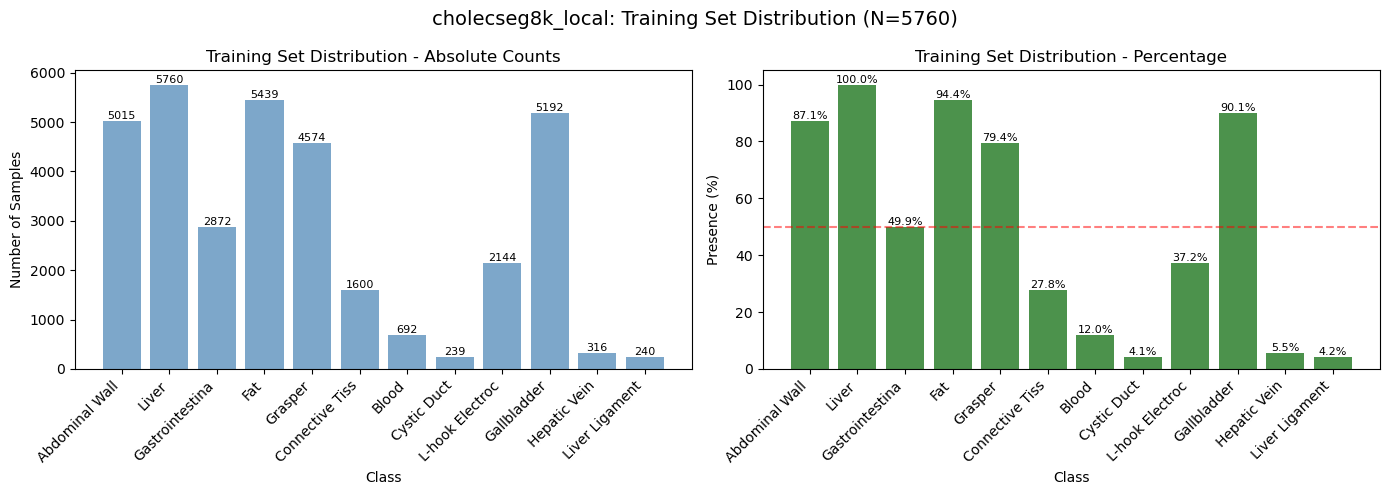


🔄 Step 2: Selecting 200 balanced test samples...
  Configuration:
    - Rare class boost: top 4 rarest classes
    - Min quota for rare classes: 40 samples (20%)
    - Cap for abundant classes: 70% of ideal balanced distribution
Loaded cached balanced indices from balanced_test_indices_advanced_200.json
  Selected 160 test samples
  Rare classes boosted: ['Cystic Duct', 'Liver Ligament', 'Hepatic Vein', 'Blood']
  Actual quota used: 40
  Cap fraction: 70.0%

📊 Selected test set distribution:
  Abdominal Wall                 140 samples ( 87.5%) ➡️ (was  87.1%)
  Liver                          160 samples (100.0%) ➡️ (was 100.0%)
  Gastrointestinal Tract         100 samples ( 62.5%) ⬆️ (was  49.9%)
  Fat                            159 samples ( 99.4%) ➡️ (was  94.4%)
  Grasper                        140 samples ( 87.5%) ⬆️ (was  79.4%)
  Connective Tissue               56 samples ( 35.0%) ⬆️ (was  27.8%)
  Blood                           24 samples ( 15.0%) ➡️ (was  12.0%)
  Cystic Duc

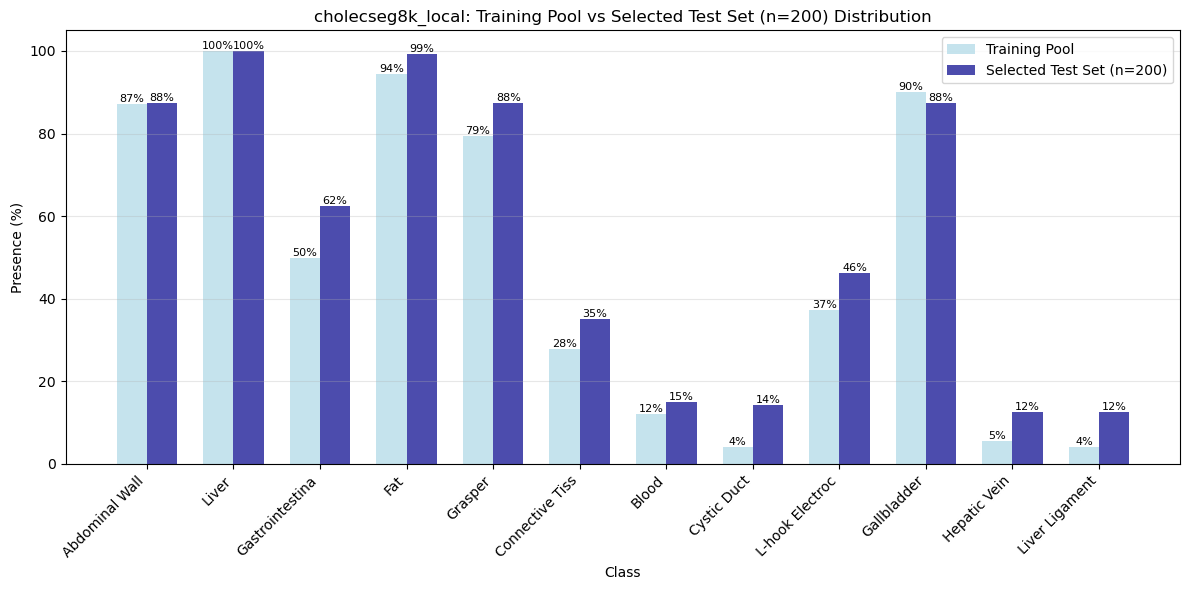


🔄 Step 3: Building pointing examples...
Loaded cached pointing plan from fewshot_plan_pointing_160.json
  Created 35 pointing examples

🔄 Step 4: Building bounding box examples...
Loaded cached bbox plan from fewshot_plan_bbox_160.json
  Created 36 bbox examples

📊 Few-Shot Example Summary
Dataset: cholecseg8k_local
Number of classes: 12
Cache directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholecseg8k_local_balanced_200
Test samples: 200

Balanced Selection Details:
  Rare classes boosted: [7, 11, 10, 6]
  Cap fraction: 70.0%

📍 Pointing Task:
  Abdominal Wall            pos=1, neg_absent=1, neg_wrong=1
  Liver                     pos=1, neg_absent=0, neg_wrong=1
  Gastrointestinal Tract    pos=1, neg_absent=1, neg_wrong=1
  Fat                       pos=1, neg_absent=1, neg_wrong=1
  Grasper                   pos=1, neg_absent=1, neg_wrong=1
  Connective Tissue         pos=1, neg_absent=1, neg_wrong=1
  Blood                     pos=1, neg_absent=1, neg_wrong=1
  Cystic 

In [5]:
# Test CholecSeg8k with 200 balanced samples
results_cholecseg8k = test_dataset("cholecseg8k_local", visualize=True)

## Test 1: CholecSeg8k (12 Organ Classes)

## Summary Comparison

Run this cell after all three datasets have been tested to see the comparison.


Testing: cholec_organs
Indexing training videos...


  Train videos: 100%|██████████| 96/96 [00:00<00:00, 528.96it/s]


Indexing test videos...


  Test videos: 100%|██████████| 25/25 [00:00<00:00, 535.50it/s]


Building examples list...


  Checking files: 100%|██████████| 1015/1015 [00:00<00:00, 3564.73it/s]


CholecOrgans dataset indexed:
  Total examples: 1015
  Train: 716 examples
  Validation: 80 examples
  Test: 219 examples

📊 Dataset Info:
  Tag: cholec_organs
  Train: 716 examples
  Val: 80 examples
  Test: 219 examples
  Classes: 3

  Class mapping:
    1: Liver
    2: Gallbladder
    3: Hepatocystic Triangle

📁 Output directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholec_organs_balanced_200

🔄 Step 1: Computing presence matrix for ALL training samples...
Loaded cached presence matrix from presence_matrix_train.npy
  Presence matrix shape: (716, 3)

📊 Class distribution in training set:
  Liver                             715 samples ( 99.9%)
  Gallbladder                       713 samples ( 99.6%)
  Hepatocystic Triangle             711 samples ( 99.3%)


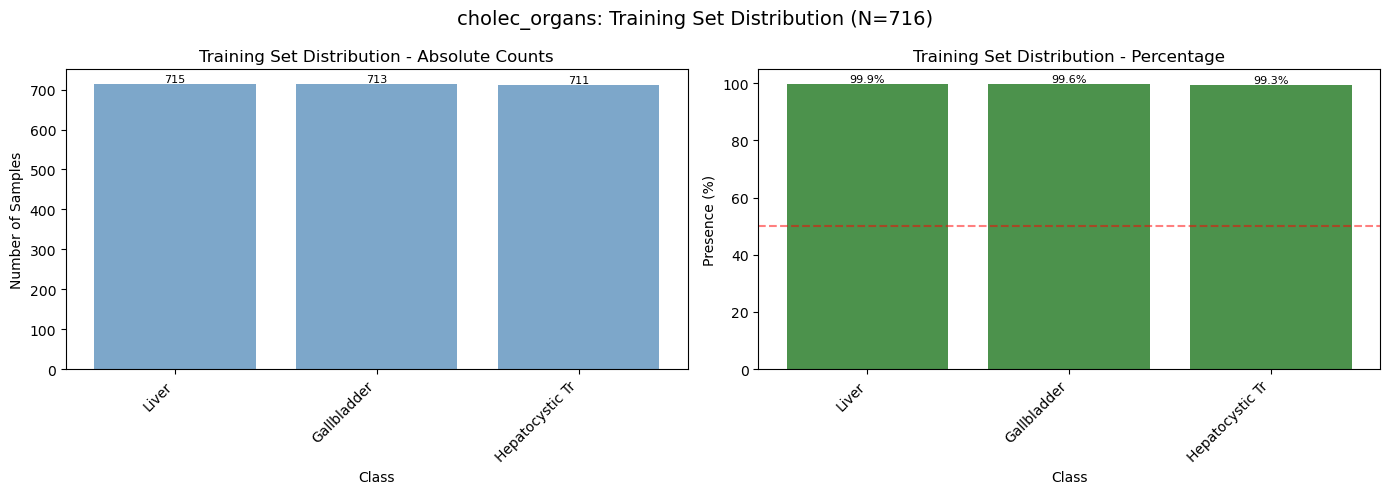


🔄 Step 2: Selecting 200 balanced test samples...
  Configuration:
    - Rare class boost: top 1 rarest classes
    - Min quota for rare classes: 40 samples (20%)
    - Cap for abundant classes: 70% of ideal balanced distribution
Loaded cached balanced indices from balanced_test_indices_advanced_200.json
  Selected 140 test samples
  Rare classes boosted: ['Hepatocystic Triangle']
  Actual quota used: 40
  Cap fraction: 70.0%

📊 Selected test set distribution:
  Liver                          140 samples (100.0%) ➡️ (was  99.9%)
  Gallbladder                    140 samples (100.0%) ➡️ (was  99.6%)
  Hepatocystic Triangle          140 samples (100.0%) ➡️ (was  99.3%)

📈 Balance Metrics:
  Original StdDev: 0.23%
  Selected StdDev: 0.00%
  Balance Improvement: 100.0%


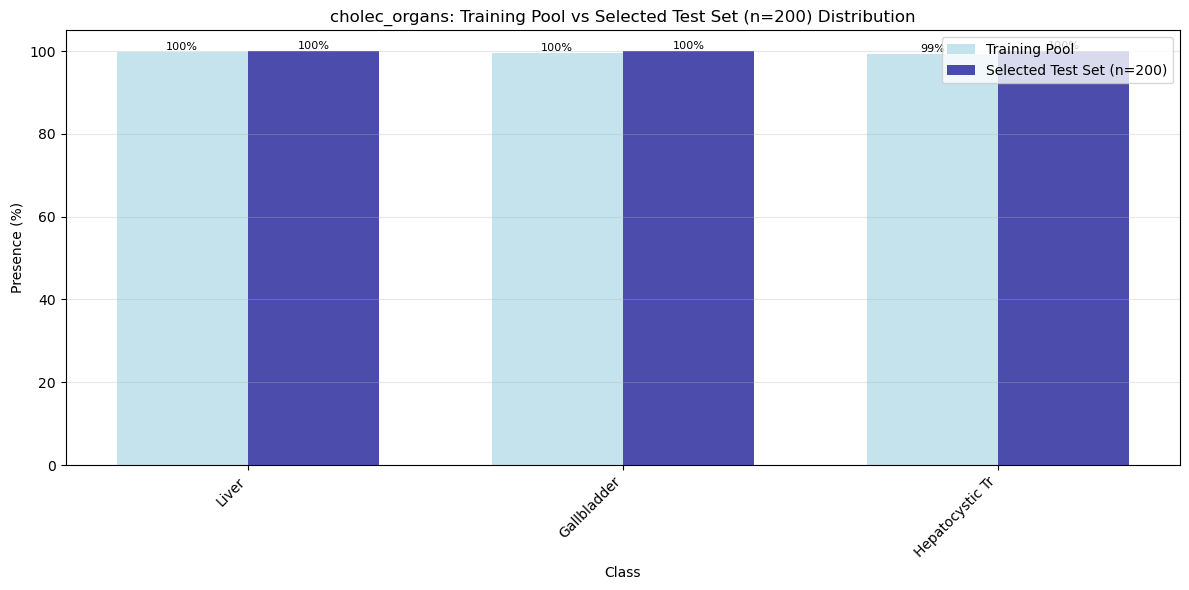


🔄 Step 3: Building pointing examples...
Loaded cached pointing plan from fewshot_plan_pointing_140.json
  Created 9 pointing examples

🔄 Step 4: Building bounding box examples...
Loaded cached bbox plan from fewshot_plan_bbox_140.json
  Created 9 bbox examples

📊 Few-Shot Example Summary
Dataset: cholec_organs
Number of classes: 3
Cache directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholec_organs_balanced_200
Test samples: 200

Balanced Selection Details:
  Rare classes boosted: [2]
  Cap fraction: 70.0%

📍 Pointing Task:
  Liver                     pos=1, neg_absent=1, neg_wrong=1
  Gallbladder               pos=1, neg_absent=1, neg_wrong=1
  Hepatocystic Triangle     pos=1, neg_absent=1, neg_wrong=1
  TOTAL                     pos=3, neg_absent=3, neg_wrong=3

📦 Bounding Box Task:
  Liver                     pos=1, neg_absent=1, neg_wrong=1
    └─ 1 positive examples have multiple regions
  Gallbladder               pos=1, neg_absent=1, neg_wrong=1
  Hepatocystic Triang

In [6]:
# Test CholecOrgans with 200 balanced samples
results_organs = test_dataset("cholec_organs", visualize=True)


Testing: cholec_organs
Indexing training videos...


  Train videos: 100%|██████████| 96/96 [00:00<00:00, 585.30it/s]


Indexing test videos...


  Test videos: 100%|██████████| 25/25 [00:00<00:00, 551.85it/s]


Building examples list...


  Checking files: 100%|██████████| 1015/1015 [00:00<00:00, 36344.55it/s]


CholecOrgans dataset indexed:
  Total examples: 1015
  Train: 716 examples
  Validation: 80 examples
  Test: 219 examples

📊 Dataset Info:
  Tag: cholec_organs
  Train: 716 examples
  Val: 80 examples
  Test: 219 examples
  Classes: 3

  Class mapping:
    1: Liver
    2: Gallbladder
    3: Hepatocystic Triangle

📁 Output directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholec_organs_balanced_200

🔄 Step 1: Computing presence matrix for ALL training samples...
Loaded cached presence matrix from presence_matrix_train.npy
  Presence matrix shape: (716, 3)

📊 Class distribution in training set:
  Liver                             715 samples ( 99.9%)
  Gallbladder                       713 samples ( 99.6%)
  Hepatocystic Triangle             711 samples ( 99.3%)


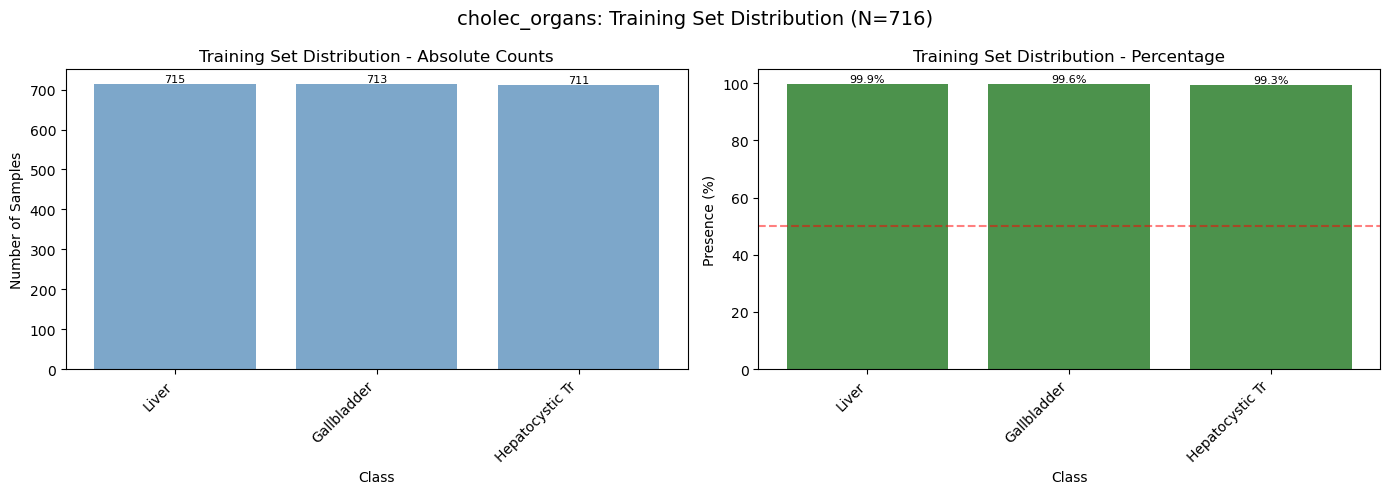


🔄 Step 2: Selecting 200 balanced test samples...
  Configuration:
    - Rare class boost: top 1 rarest classes
    - Min quota for rare classes: 40 samples (20%)
    - Cap for abundant classes: 70% of ideal balanced distribution
Loaded cached balanced indices from balanced_test_indices_advanced_200.json
  Selected 140 test samples
  Rare classes boosted: ['Hepatocystic Triangle']
  Actual quota used: 40
  Cap fraction: 70.0%

📊 Selected test set distribution:
  Liver                          140 samples (100.0%) ➡️ (was  99.9%)
  Gallbladder                    140 samples (100.0%) ➡️ (was  99.6%)
  Hepatocystic Triangle          140 samples (100.0%) ➡️ (was  99.3%)

📈 Balance Metrics:
  Original StdDev: 0.23%
  Selected StdDev: 0.00%
  Balance Improvement: 100.0%


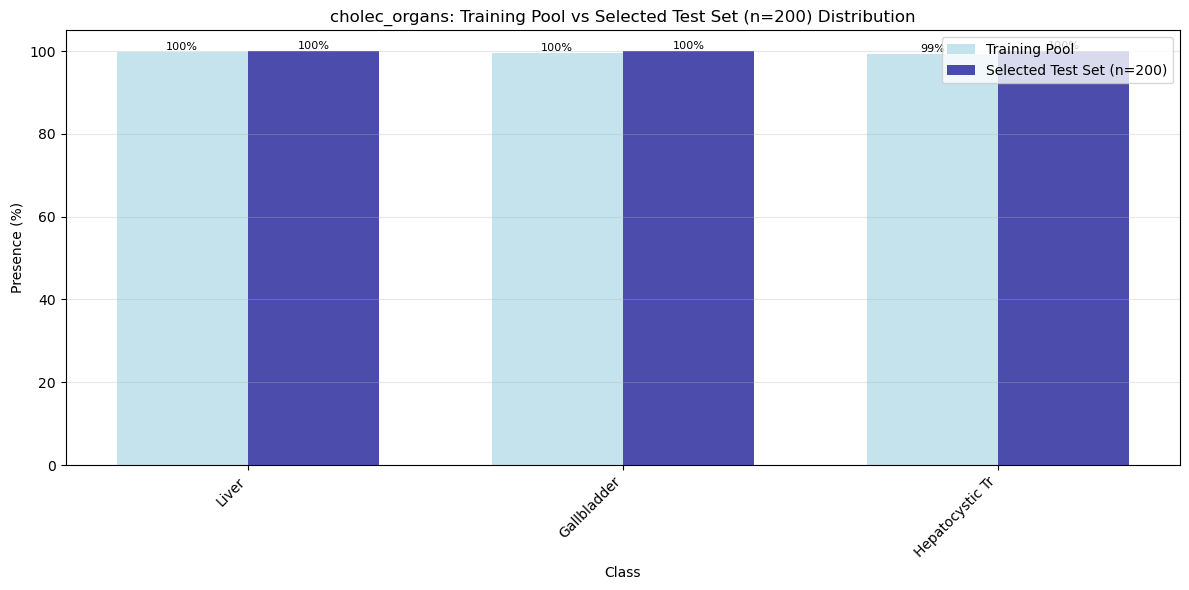


🔄 Step 3: Building pointing examples...
Loaded cached pointing plan from fewshot_plan_pointing_140.json
  Created 9 pointing examples

🔄 Step 4: Building bounding box examples...
Loaded cached bbox plan from fewshot_plan_bbox_140.json
  Created 9 bbox examples

📊 Few-Shot Example Summary
Dataset: cholec_organs
Number of classes: 3
Cache directory: /shared_data0/weiqiuy/llm_cholec_organ/data_info/cholec_organs_balanced_200
Test samples: 200

Balanced Selection Details:
  Rare classes boosted: [2]
  Cap fraction: 70.0%

📍 Pointing Task:
  Liver                     pos=1, neg_absent=1, neg_wrong=1
  Gallbladder               pos=1, neg_absent=1, neg_wrong=1
  Hepatocystic Triangle     pos=1, neg_absent=1, neg_wrong=1
  TOTAL                     pos=3, neg_absent=3, neg_wrong=3

📦 Bounding Box Task:
  Liver                     pos=1, neg_absent=1, neg_wrong=1
    └─ 1 positive examples have multiple regions
  Gallbladder               pos=1, neg_absent=1, neg_wrong=1
  Hepatocystic Triang

In [7]:
results_organs = test_dataset("cholec_organs", visualize=True)

In [8]:
print("\n" + "="*70)
print("✨ 200 Balanced Test Samples Generation Complete!")
print("="*70)

print("\n✅ Successfully generated 200 balanced test samples for:")
print("  1. CholecSeg8k: 12 organ classes")
print("  2. CholecOrgans: 3 organ classes (Liver, Gallbladder, Hepatocystic Triangle)")
print("  3. CholecGoNoGo: 2 classes (Go/Safe, NoGo/Unsafe regions)")

print("\n📊 Key Features of the 200-Sample Test Sets:")
print("  • Consistent test size across all datasets (exactly 200 samples each)")
print("  • Advanced balanced selection with rare class boosting")
print("  • Automatic parameter tuning based on dataset characteristics")
print("  • Comprehensive few-shot examples for both pointing and bounding box tasks")
print("  • Efficient caching system for faster re-runs")

print("\n📈 Balance Improvements Achieved:")
for res in all_results:
    improvement = res['balance_metrics']['improvement_percent']
    print(f"  • {res['dataset_name']}: {improvement:+.1f}% better balance than random sampling")

print("\n📁 Output directories with 200 balanced samples:")
for res in all_results:
    print(f"  • {res['output_dir']}")
    indices_file = Path(res['output_dir']) / "balanced_test_indices_advanced_200.json"
    if indices_file.exists():
        print(f"    └── Test indices: {indices_file.name}")

print("\n🎯 Next Steps:")
print("  1. Use these 200 balanced test samples for consistent evaluation across datasets")
print("  2. The few-shot examples are already generated and cached")
print("  3. Compare model performance across the different surgical datasets")
print("  4. Analyze which classes benefit most from balanced selection")

print("\n💡 Tips:")
print("  • Re-running the notebook will use cached results (much faster)")
print("  • To regenerate, delete the cache files in the output directories")
print("  • The 200-sample size ensures statistical significance while being computationally manageable")


✨ 200 Balanced Test Samples Generation Complete!

✅ Successfully generated 200 balanced test samples for:
  1. CholecSeg8k: 12 organ classes
  2. CholecOrgans: 3 organ classes (Liver, Gallbladder, Hepatocystic Triangle)
  3. CholecGoNoGo: 2 classes (Go/Safe, NoGo/Unsafe regions)

📊 Key Features of the 200-Sample Test Sets:
  • Consistent test size across all datasets (exactly 200 samples each)
  • Advanced balanced selection with rare class boosting
  • Automatic parameter tuning based on dataset characteristics
  • Comprehensive few-shot examples for both pointing and bounding box tasks
  • Efficient caching system for faster re-runs

📈 Balance Improvements Achieved:


NameError: name 'all_results' is not defined

In [ ]:
results_gonogo = test_dataset("cholec_gonogo", visualize=True)

## Summary Comparison

## Visualize Example Selection Quality

In [ ]:
def visualize_few_shot_example(dataset, plan, class_name, example_type="positive"):
    """Visualize a single few-shot example."""
    # Find the class info
    class_info = None
    for class_id_str, info in plan['plan'].items():
        if info['name'] == class_name:
            class_info = info
            break
    
    if class_info is None:
        print(f"Class {class_name} not found")
        return
    
    # Get example based on type
    if example_type == "positive" and class_info['positives']:
        ex = class_info['positives'][0]
        title = f"✅ Positive: {class_name}"
    elif example_type == "negative_absent" and class_info['negatives_absent']:
        ex = class_info['negatives_absent'][0]
        title = f"❌ Negative (absent): No {class_name}"
    elif example_type == "negative_wrong" and 'negatives_wrong_bbox' in class_info and class_info['negatives_wrong_bbox']:
        ex = class_info['negatives_wrong_bbox'][0]
        title = f"⚠️ Negative (wrong): {class_name} with wrong bbox"
    else:
        print(f"No {example_type} example found for {class_name}")
        return
    
    # Load and display the example
    example = dataset.get_example(plan['split'], ex['idx'])
    
    plt.figure(figsize=(8, 6))
    plt.imshow(example['image'])
    
    # Draw bounding boxes if present
    if 'bboxes' in ex and ex['bboxes']:
        for bbox in ex['bboxes']:
            x1, y1, x2, y2 = bbox
            color = 'green' if example_type == "positive" else 'red'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor=color,
                                    facecolor='none', alpha=0.7)
            plt.gca().add_patch(rect)
    
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example: Visualize some examples from CholecSeg8k
if results_cholecseg8k['bbox_plan']:
    print("\n📸 Example Few-Shot Visualizations (CholecSeg8k)")
    print("="*50)
    
    dataset = build_dataset("cholecseg8k_local", **DATASET_CONFIGS["cholecseg8k_local"])
    
    # Show examples for Liver
    visualize_few_shot_example(dataset, results_cholecseg8k['bbox_plan'], "Liver", "positive")
    
    # Show examples for Gallbladder
    visualize_few_shot_example(dataset, results_cholecseg8k['bbox_plan'], "Gallbladder", "positive")

In [ ]:
print("\n" + "="*70)
print("✨ Unified Few-Shot Selector Test Complete!")
print("="*70)

print("\n✅ Successfully tested with:")
print("  1. CholecSeg8k: 12 organ classes")
print("  2. CholecOrgans: 3 organ classes (Liver, Gallbladder, Hepatocystic Triangle)")
print("  3. CholecGoNoGo: 2 classes (Go/Safe, NoGo/Unsafe regions)")

print("\n📊 Key Features Demonstrated:")
print("  • Automatic parameter configuration based on dataset")
print("  • Advanced balanced selection with rare class boosting")
print("  • Support for both pointing and bounding box tasks")
print("  • Efficient caching system")
print("  • Works with ANY dataset following the protocol")

print("\n📁 Output directories created:")
for res in all_results:
    print(f"  • {res['output_dir']}")

print("\n🎯 Next Steps:")
print("  1. Use the generated few-shot examples for LLM evaluation")
print("  2. Compare zero-shot vs few-shot performance")
print("  3. Analyze which negative types are most challenging")
print("  4. Fine-tune selection parameters for specific datasets")